<a href="https://colab.research.google.com/github/nazmulhasan77/CKD-Biomarker-Identification/blob/main/CKD_Biomarker_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount Drive & imports
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 15.3 MB/s eta 0:00:00


In [ ]:
# ------------------------------
# 1️⃣ Imports
# ------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, zscore
from statsmodels.stats.multitest import multipletests
#!pip install gseapy
import gseapy as gp  # for enrichment analysis

In [ ]:
#Load expression matrix (genes × samples)
expr_file = '/content/drive/MyDrive/BioResearch/GSE66494_series_matrix.txt.gz'

expr = pd.read_csv(
    expr_file,
    sep='\t',
    comment='!',
    index_col=0,
    compression='gzip'
)

expr.head()


,GSM1623299,GSM1623300,GSM1623301,GSM1623302,GSM1623303,GSM1623304,GSM1623305,GSM1623306,GSM1623307,GSM1623308,...,GSM1623350,GSM1623351,GSM1623352,GSM1623353,GSM1623354,GSM1623355,GSM1623356,GSM1623357,GSM1623358,GSM1623359
ID_REF,,,,,,,,,,,,,,,,,,,,,
A_23_P100001,4.130915,7.196451,4.447412,5.552394,7.488012,6.001083,2.394743,10.043503,3.784250,2.627315,...,3.048840,3.053362,1.760907,5.129226,2.953872,3.183397,4.535605,4.068553,3.936768,3.807201
A_23_P100011,0.147132,0.210062,0.160009,0.107925,0.090619,0.266602,0.302839,0.410110,0.317810,0.442425,...,0.301012,0.361652,0.734535,0.125607,0.225909,0.168436,0.343899,0.350141,0.405691,0.399181
A_23_P100022,3.907870,3.327555,1.916772,1.483245,8.623109,1.720839,2.846809,1.098986,2.608736,1.086212,...,0.646545,0.686610,3.167144,6.389475,2.848148,3.598935,1.240645,0.876765,0.792963,0.805732
A_23_P100056,0.426146,0.401487,2.426482,0.808467,0.420939,3.200327,0.746913,1.840242,1.735957,2.251156,...,1.816479,1.714723,1.815770,1.258793,1.532383,0.444932,0.357534,2.735043,2.532193,2.762726
A_23_P100074,5.230722,3.833417,13.161534,13.673666,10.147046,21.019512,5.356592,19.088257,12.063126,17.395967,...,6.934141,7.064570,4.215108,6.569894,15.609033,8.387245,6.876524,8.062073,8.150031,7.977626


In [ ]:
import gzip

soft_file = '/content/drive/MyDrive/BioResearch/GSE66494_family.soft.gz'

groups = {}
current_gsm = None

with gzip.open(soft_file, 'rt') as f:
    for line in f:

        # detect new sample
        if line.startswith('^SAMPLE'):
            current_gsm = line.strip().split(' = ')[1]

        # read characteristics
        if line.startswith('!Sample_characteristics_ch1') and current_gsm:
            text = line.lower()

            if 'ckd' in text or 'chronic' in text or 'fibrosis' in text:
                groups[current_gsm] = 'CKD'

            elif 'normal' in text or 'control' in text:
                groups[current_gsm] = 'Normal'

# preview
print("Total samples:", len(groups))
print("CKD:", list(groups.values()).count('CKD'))
print("Normal:", list(groups.values()).count('Normal'))

print(list(groups.items())[:10])


Total samples: 61
CKD: 53
Normal: 8
[('GSM1623299', 'CKD'), ('GSM1623300', 'CKD'), ('GSM1623301', 'CKD'), ('GSM1623302', 'CKD'), ('GSM1623303', 'CKD'), ('GSM1623304', 'CKD'), ('GSM1623305', 'CKD'), ('GSM1623306', 'CKD'), ('GSM1623307', 'CKD'), ('GSM1623308', 'CKD')]


In [ ]:
ckd_samples = [g for g,v in groups.items() if v=='CKD' and g in expr.columns]
normal_samples = [g for g,v in groups.items() if v=='Normal' and g in expr.columns]

ckd_samples[:5], normal_samples[:5]


(['GSM1623299', 'GSM1623300', 'GSM1623301', 'GSM1623302', 'GSM1623303'],
 ['GSM1623347', 'GSM1623348', 'GSM1623349', 'GSM1623350', 'GSM1623351'])

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# ------------------------------------------------
# CKD vs Normal Differential Expression
# ------------------------------------------------
def differential_expression_ckd(df, groups, min_samples=2):
    """
    Differential expression for GSE66494
    CKD vs Normal

    Parameters
    ----------
    df : expression matrix (genes x samples)
    groups : dict {GSM : 'CKD' or 'Normal'}
    min_samples : minimum samples per group

    Returns
    -------
    DataFrame with log2FC, pvalue, -log10(pvalue)
    """

    # split samples
    ckd_samples = [s for s,g in groups.items() if g == 'CKD' and s in df.columns]
    normal_samples = [s for s,g in groups.items() if g == 'Normal' and s in df.columns]

    print(f"CKD samples: {len(ckd_samples)}")
    print(f"Normal samples: {len(normal_samples)}")

    results = []

    for gene in df.index:
        g_ckd = df.loc[gene, ckd_samples].dropna()
        g_normal = df.loc[gene, normal_samples].dropna()

        if len(g_ckd) < min_samples or len(g_normal) < min_samples:
            continue

        # CKD − Normal (important for interpretation)
        log2fc = np.log2(g_ckd.mean() + 1) - np.log2(g_normal.mean() + 1)

        stat, pval = ttest_ind(g_ckd, g_normal, equal_var=False)

        results.append((gene, log2fc, pval))

    res = pd.DataFrame(results, columns=['gene','log2FC','pvalue'])
    res.set_index('gene', inplace=True)

    res['-log10(pvalue)'] = -np.log10(res['pvalue'])

    # sort by significance
    res = res.sort_values('pvalue')

    return res


In [ ]:
vol_CKDvsN = differential_expression_ckd(
    expr,
    groups
)

CKD samples: 53
Normal samples: 8


In [ ]:
from statsmodels.stats.multitest import multipletests

vol_CKDvsN['FDR'] = multipletests(
    vol_CKDvsN['pvalue'],
    method='fdr_bh'
)[1]


In [ ]:
# ---------------------------------
# Classify genes (CKD vs Normal)
# ---------------------------------

fc_thresh = 1        # recommended (2-fold change)
fdr_thresh = 0.05    # standard

vol_CKDvsN['category'] = 'Stable'

# CKD upregulated
vol_CKDvsN.loc[
    (vol_CKDvsN['log2FC'] >= fc_thresh) & (vol_CKDvsN['FDR'] < fdr_thresh),
    'category'
] = 'Up'

# CKD downregulated
vol_CKDvsN.loc[
    (vol_CKDvsN['log2FC'] <= -fc_thresh) & (vol_CKDvsN['FDR'] < fdr_thresh),
    'category'
] = 'Down'

vol_CKDvsN['category'].value_counts()


,count
category,
Stable,38523
Up,1957
Down,520


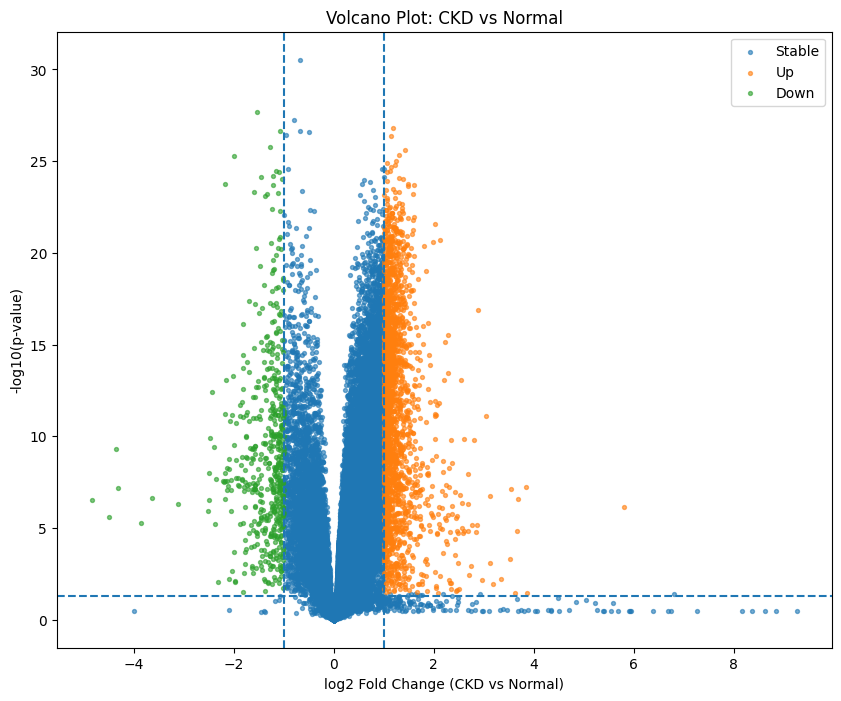

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,8))

for cat in ['Stable', 'Up', 'Down']:
    sub = vol_CKDvsN[vol_CKDvsN['category'] == cat]

    plt.scatter(
        sub['log2FC'],
        sub['-log10(pvalue)'],
        s=8,
        alpha=0.6,
        label=cat
    )

# significance lines
plt.axhline(-np.log10(0.05), linestyle='--')
plt.axvline(1, linestyle='--')
plt.axvline(-1, linestyle='--')

plt.xlabel('log2 Fold Change (CKD vs Normal)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: CKD vs Normal')
plt.legend()

plt.show()


In [ ]:
top50_genes = (
    vol_CKDvsN
    .query('FDR < 0.05')
    .assign(absFC=lambda x: abs(x['log2FC']))
    .sort_values('absFC', ascending=False)
    .head(50)
    .index
)

print("Top genes selected:", len(top50_genes))


Top genes selected: 50


In [ ]:
# Without Stable
top50_genes = (
    vol_CKDvsN
    .query('category != "Stable" and FDR < 0.05')
    .assign(absFC=lambda x: abs(x['log2FC']))
    .sort_values('absFC', ascending=False)
    .head(50)
    .index
)
print("Top genes selected without stable:", len(top50_genes))


Top genes selected without stable: 50


In [ ]:
# Top 50 genes (CKD vs Normal)
top50_genes_list = list(top50_genes)  # convert index to list

print("Top 50 CKD genes:")
for i, gene in enumerate(top50_genes_list, 1):
    print(f"{i}. {gene}")


Top 50 CKD genes:
1. A_24_P500584
2. A_23_P95790
3. A_23_P58266
4. A_23_P321501
5. A_23_P48570
6. A_23_P200579
7. A_24_P217330
8. A_23_P52761
9. A_23_P166848
10. A_24_P922631
11. A_23_P389500
12. A_32_P143377
13. A_24_P922101
14. A_23_P136125
15. A_23_P43979
16. A_23_P422144
17. A_32_P20997
18. A_23_P121533
19. A_23_P123853
20. A_24_P892790
21. A_24_P104980
22. A_24_P930551
23. A_24_P924185
24. A_24_P148907
25. A_23_P33673
26. A_23_P502520
27. A_32_P200144
28. A_23_P167349
29. A_32_P11764
30. A_24_P237328
31. A_23_P218675
32. A_24_P381199
33. A_32_P225768
34. A_23_P91230
35. A_24_P38572
36. A_24_P306945
37. A_24_P82358
38. A_24_P682285
39. A_23_P315320
40. A_24_P75190
41. A_23_P111188
42. A_23_P158817
43. A_24_P497244
44. A_23_P215669
45. A_23_P256008
46. A_24_P258235
47. A_23_P397376
48. A_24_P52597
49. A_23_P136296
50. A_23_P201459


In [ ]:
# Use CKD and Normal samples
samples = ckd_samples + normal_samples

# Extract top 50 gene expression
heatmap_data = expr.loc[top50_genes, samples]

# preview
heatmap_data.head()


,GSM1623299,GSM1623300,GSM1623301,GSM1623302,GSM1623303,GSM1623304,GSM1623305,GSM1623306,GSM1623307,GSM1623308,...,GSM1623355,GSM1623356,GSM1623347,GSM1623348,GSM1623349,GSM1623350,GSM1623351,GSM1623357,GSM1623358,GSM1623359
gene,,,,,,,,,,,,,,,,,,,,,
A_24_P500584,171.735022,218.067839,0.101391,0.389689,0.309178,0.128919,207.180515,0.925676,167.267507,52.363189,...,242.198420,0.385606,0.107426,0.129785,0.082407,0.100550,0.091976,0.126808,0.109027,0.115375
A_23_P95790,3.931688,0.689558,3.725749,22.709390,13.300830,1.156827,4.356585,1.189394,13.083451,8.267488,...,1.036268,0.847032,290.767533,261.266475,273.129067,283.765400,280.861745,378.905613,368.581110,364.292656
A_23_P58266,0.149016,0.921177,0.062422,0.424002,0.363567,0.084975,0.717587,0.197414,0.231950,0.071867,...,0.155380,0.407507,27.380711,26.476795,28.043017,27.109638,26.611234,41.504631,37.960759,38.673060
A_23_P321501,0.594319,0.556821,0.813634,0.796869,0.249575,1.178564,1.429451,2.483181,1.227619,0.843806,...,0.293987,0.370144,44.153862,41.009385,42.856216,37.162600,38.538130,44.502649,40.768316,40.865220
A_23_P48570,0.209097,0.320422,0.777925,0.674657,0.108466,0.971372,1.457116,2.431830,1.265387,0.676894,...,0.143495,0.424646,38.236934,35.635730,34.541270,30.228228,32.072497,42.368066,40.750699,40.832873


In [ ]:
from scipy.stats import zscore

# Row-wise Z-score normalization (genes)
heatmap_z = heatmap_data.apply(lambda x: zscore(x, nan_policy='omit'), axis=1)
heatmap_z.head()


,0
gene,
A_24_P500584,"[1.5757095825070453, 2.190202048341437, -0.700..."
A_23_P95790,"[-0.4334211391890175, -0.4641346150283714, -0...."
A_23_P58266,"[-0.40745691281084684, -0.3358610771126924, -0..."
A_23_P321501,"[-0.4214574615309317, -0.4242126526130249, -0...."
A_23_P48570,"[-0.44119022023938614, -0.43209778542794475, -..."


In [ ]:
import seaborn as sns
import pandas as pd

# Sample labels for CKD dataset
group_labels = ['CKD']*len(ckd_samples) + ['Normal']*len(normal_samples)
#samples = ckd_samples + normal_samples  # ensure order matches
sample_group = pd.Series(group_labels, index=samples)

# Color mapping
col_colors = sample_group.map({
    'CKD': '#d62728',      # red
    'Normal': '#1f77b4'    # blue
})

# preview
sample_group.head()
col_colors.head()


,0
GSM1623299,#d62728
GSM1623300,#d62728
GSM1623301,#d62728
GSM1623302,#d62728
GSM1623303,#d62728


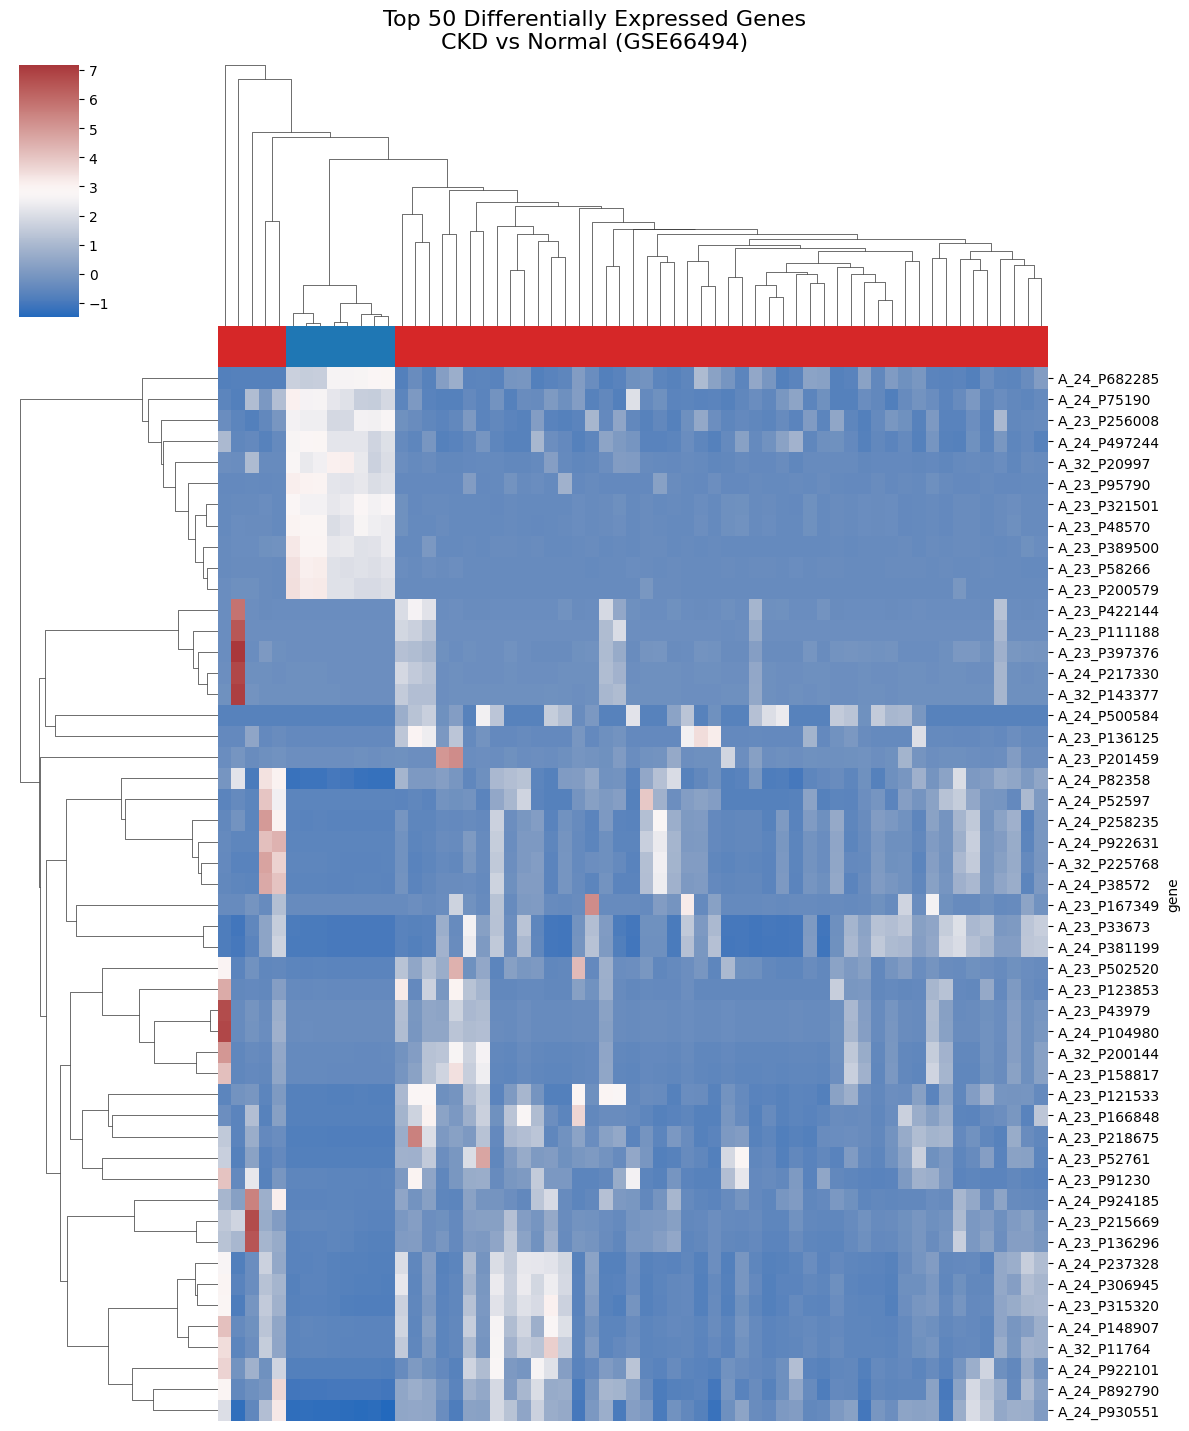

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported for vstack

# Ensure samples order matches heatmap columns
samples = ckd_samples + normal_samples

# The heatmap_z from the previous cell is a pandas Series where each entry is a numpy array of z-scores.
# It needs to be converted into a DataFrame with genes as index and samples as columns.
# We reconstruct the DataFrame using numpy.vstack to stack the arrays, and assign the original index and columns.
heatmap_z = pd.DataFrame(np.vstack(heatmap_z.values), index=heatmap_z.index, columns=heatmap_data.columns)

# Now, with heatmap_z as a proper DataFrame, we can reorder its columns.
heatmap_z = heatmap_z[samples]

# Sample annotation colors
col_colors = pd.Series(
    ['#d62728']*len(ckd_samples) + ['#1f77b4']*len(normal_samples),
    index=samples
)

# Plot top-50 DEG heatmap with sample annotation
sns.clustermap(
    heatmap_z,
    cmap='vlag',
    col_colors=col_colors.to_numpy(),
    figsize=(12, 14),
    xticklabels=False,
    yticklabels=True
)

plt.suptitle(
    'Top 50 Differentially Expressed Genes\nCKD vs Normal (GSE66494)',
    y=1.02,
    fontsize=16
)

plt.show()

In [ ]:
# ------------------------------
# 7️⃣ Candidate biomarkers table
# ------------------------------

fdr_thresh = 0.05  # FDR cutoff

# Focus on top 100 DEGs (Up + Down)
top_DEGs = vol_CKDvsN.query('FDR < @fdr_thresh').sort_values('FDR').head(100)

# If you have known CKD biomarker genes, list them here
# Example list (replace/add as per literature)
known_ckd_genes = ['HAVCR1','NPHS1','UMOD','SLC12A3','COL4A3','COL1A1','ACTA2']

# Flag if gene is known CKD biomarker
top_DEGs['Known_CKD'] = top_DEGs.index.isin(known_ckd_genes)

# Show table
top_DEGs[['log2FC','pvalue','FDR','category','Known_CKD']].head(20)


,log2FC,pvalue,FDR,category,Known_CKD
gene,,,,,
A_32_P90468,-0.669493,2.938504e-31,1.204787e-26,Stable,False
A_23_P15727,-1.529304,2.032069e-28,4.165742e-24,Down,False
A_23_P105144,-0.791467,5.558796e-28,7.597022e-24,Stable,False
A_23_P163117,1.193489,1.545385e-27,1.516629e-23,Up,False
A_32_P201897,-0.490317,2.589366e-27,1.516629e-23,Stable,False
A_23_P95972,-0.667558,2.344541e-27,1.516629e-23,Stable,False
A_23_P374689,-1.080777,2.318115e-27,1.516629e-23,Down,False
A_23_P106617,-0.948556,3.885559e-27,1.967262e-23,Stable,False
A_32_P207428,1.150823,4.318380e-27,1.967262e-23,Up,False


In [ ]:
# ------------------------------
# Example: minimal probe → gene mapping for CKD
# Replace with full GEO annotation for all probes
probe2gene_ckd = {
    '11728232_a_at':'HAVCR1',
    '11732838_at':'NPHS1',
    '11715637_a_at':'UMOD',
    '11724538_a_at':'SLC12A3',
    '11726764_a_at':'COL4A3',
    '11733581_a_at':'ACTA2'
    # Add other CKD-related probes from GEO annotation
}

# Map probe → gene symbol
vol_CKDvsN['GeneSymbol'] = vol_CKDvsN.index.map(probe2gene_ckd)

# Known CKD biomarkers list
known_ckd_genes = ['HAVCR1','NPHS1','UMOD','SLC12A3','COL4A3','ACTA2']

# Mark known CKD genes
vol_CKDvsN['Known_CKD'] = vol_CKDvsN['GeneSymbol'].isin(known_ckd_genes)

# Filter top DEGs that are known CKD biomarkers
candidate_biomarkers = vol_CKDvsN.query('Known_CKD == True').sort_values('FDR')

# Show table
candidate_biomarkers[['GeneSymbol','log2FC','pvalue','FDR','category']]


,GeneSymbol,log2FC,pvalue,FDR,category
gene,,,,,


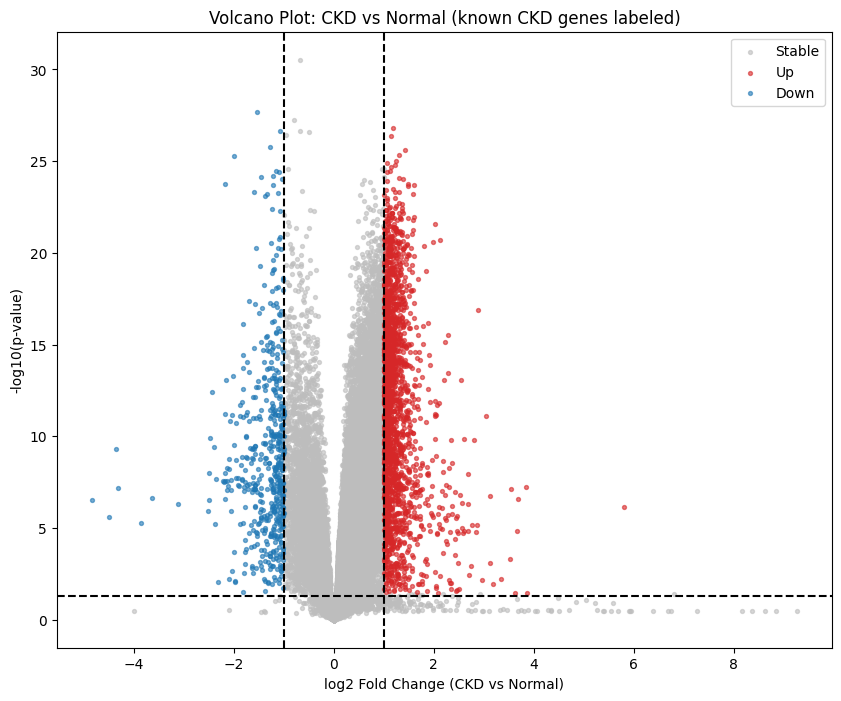

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,8))

# Colors for Up/Down/Stable
colors = {'Up':'#d62728','Down':'#1f77b4','Stable':'#bdbdbd'}

# Scatter plot
for cat in ['Stable','Up','Down']:
    sub = vol_CKDvsN[vol_CKDvsN['category']==cat]
    plt.scatter(
        sub['log2FC'],
        sub['-log10(pvalue)'],
        s=8,
        alpha=0.6,
        c=colors[cat],
        label=cat
    )

# Threshold lines
plt.axhline(-np.log10(fdr_thresh), linestyle='--', color='black')
plt.axvline(fc_thresh, linestyle='--', color='black')
plt.axvline(-fc_thresh, linestyle='--', color='black')

# Label known CKD genes
for i, row in vol_CKDvsN[vol_CKDvsN['Known_CKD']].iterrows():
    plt.text(
        row['log2FC'],
        row['-log10(pvalue)'],
        row['GeneSymbol'],
        fontsize=9,
        color='black'
    )

plt.xlabel('log2 Fold Change (CKD vs Normal)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: CKD vs Normal (known CKD genes labeled)')
plt.legend()
plt.show()
